# "Inflow of surface and groundwaters from neighbouring countries"
This data from the [UN data store](http://data.un.org/Data.aspx?d=ENV&f=variableID%3a8), joined with data from [Kaggle](https://www.kaggle.com/fernandol/countries-of-the-world), reports inflow into countries from neighboring countries for 62 of the UN's 193 member countires (e.g. the USA is not in this dataset, for an undiscolsed reason).

__Exersise reflection__: While this thin datasets leaves more questions than answers, misses many countries, and the exploration could have benefited from actual geo libraries, I got a great chance to brush up on matplotlib and get a sense for Pandas' API.

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 0. Data Prep
Create master data setting by joining 3 datasets
1. water inflow
2. lat long
3. general stats (pop etc)

In [185]:
# Dataset disagregated by year
inflow_df = pd.read_csv('UN_data_water_from_other_countries.csv')
# Aggregate by country, averaging yearly inflow
inflow_by_country_df = inflow_df.groupby('Country or Area').mean()
country_lat_long = pd.read_csv('country_lat_long.csv')
lat_lon_df = inflow_by_country_df.merge(
    country_lat_long,
    how='inner',
    left_on='Country or Area',
    right_on='name',
)

# Cast string numbers to numerics
lat_lon_df["latitude"] = pd.to_numeric(lat_lon_df["latitude"])
lat_lon_df["longitude"] = pd.to_numeric(lat_lon_df["longitude"])

world_general = pd.read_csv('countries of the world.csv')
world_general['Country'] = world_general['Country'].str.strip() # the Kaggle dataset had huge trailing whitespaces

df_final = world_general.merge(
    lat_lon_df,
    how='inner',
    left_on='Country',
    right_on='name',
)

# 1. Distribution of Inflow of Water into Countries over time

(For the purposes of this short assignment, just imagine the chart is interactive and you can hover to see the country name.)


__Note__ that countries did not uniformly report inflow, so some years are missing or begin the timeseries begins later than others.

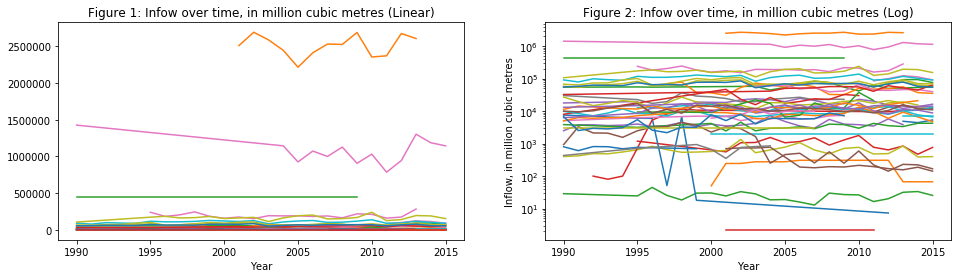

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,4))
inflow_df.groupby('Country or Area').plot(
	x='Year', 
	y='Value', 
	ax=ax1, 
	title='Figure 1: Infow over time, in million cubic metres (Linear)',
	legend=False
)
inflow_df.groupby('Country or Area').plot(
	logy=True,
	x='Year', 
	y='Value', 
	ax=ax2, 
	title='Figure 2: Infow over time, in million cubic metres (Log)',
	legend=False
)
plt.ylabel('Inflow, in million cubic metres')
plt.show()

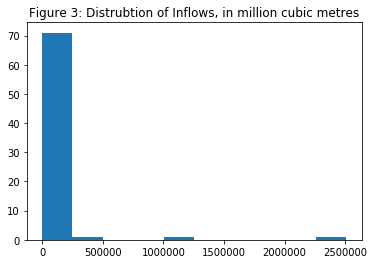

In [187]:
plt.hist(inflow_by_country_df['Value'])
plt.title('Figure 3: Distrubtion of Inflows, in million cubic metres')
plt.show()

__Figures 1 and 2__ provide an entry point for interrogating the dataset. They reveal: 
- The distribution of inflows: heavily distributed around 10k-100k million cupic meters, with outliers Brazil, Bangladesh, and Serbia recieving much higher inflows. Efficiently, Figure 1 serves both as a linearly scaled timeseries *and* __a rotated histogram of sorts__ conveying the distribution of inflows. Compare its visual effectiveness to that to an a more traditional histogram in Figure 3, which takes the average of all yearly inflows.
- The reletive consistency over time of most inflows, as well as some notable outliers (see Serbia in pink changing between 2013 and 2015)

They also raise important questions:
- How much is water *outflowing* from each country? (ie net flow)
- How significant are the changes we see over time for each country?
- Where might flunctions in inflow originate -- ie how much depends on nature, and how much on the choices of upstream neighbors?
- Relatedly, does geographic position influence patterns in water infow?

## 2. Greographic Placement of countries on the inflow extremes, with dot sized by population

In [188]:
def plot_lat_long(df, title, constrain_axis=False):
    fig, ax = plt.subplots()
    lat = df['latitude']
    lon = df['longitude']
    val = df['Value']
    dot_size = [n/500000 for n in df['Population']]
    ax.scatter(x=lon, y=lat, c=val, s=dot_size)
    if constrain_axis:
        ax.set_xlim(-180, 180)
        ax.set_ylim(-90, 90)
    ax.set_title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    for index, row in df.iterrows():
        x_text_offset = 2
        ax.annotate(s=row['Country'], xy=(row['longitude'] + x_text_offset, row['latitude']))
    plt.show()

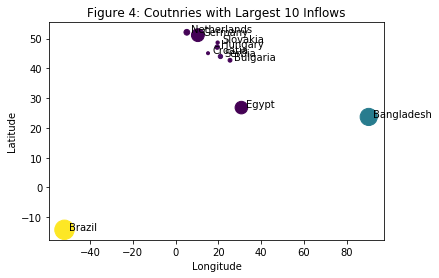

In [189]:
biggest_df = df_final.nlargest(10, 'Value')
plot_lat_long(biggest_df, 'Figure 4: Coutnries with Largest 10 Inflows')

__Figure 4: Coutnries with Largest 10 Inflows__ reveals huge inflows in Europe, where tightly clustered countries share water resources. Brazil, not surprisingly, collects inflow from its tropical neighbors. Dot size gives a rough sense of how much water the country may require for human consumption, as in Figure 5. This figure may be somewhat correlated to -- but also perhaps highly skewed by -- other water-intensive activites such as levels of crop production.

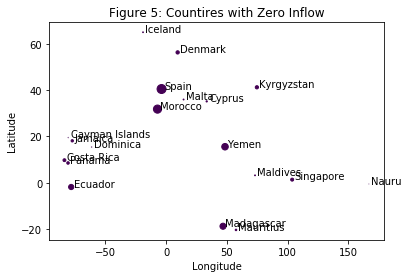

In [190]:
smallest_df = df_final[df_final['Value'] < 1]
plot_lat_long(smallest_df, 'Figure 5: Countires with Zero Inflow')

__Figure 5: Countires with Zero Inflow__ distinguishes two types of zero-inflow countires:
1. island countries like Iceland and Madagascar and
2. a few intriguing neighbored countries, begging further investigation into their neighbors, natural environment, or perhas data errors.